In [87]:
import warnings
warnings.filterwarnings("ignore")

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', -1)

In [89]:
#loading data
train_df = pd.read_csv('./train.csv', index_col=False)
train_df.shape

(1460, 81)

In [90]:
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Features Description

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=data_description.txt

# Handling Missing Data

In [91]:
def get_feature_types_stats(df):
    features = df.dtypes.rename('feature_type').reset_index().rename(columns={'index':'feature'})
    return features

In [92]:
def get_feature_stats(df):
    missing_stats = df.isna().sum().rename('missing_count').reset_index().rename(columns={'index':'feature'})
    missing_stats['missing_percentage'] = missing_stats['missing_count']/df.shape[0]
    
    feature_types_df = get_feature_types_stats(df)
    
    missing_stats = missing_stats.merge(feature_types_df,
                         left_on='feature',
                         right_on='feature',
                         how='left')
    return missing_stats

In [93]:
missing_stats = get_feature_stats(train_df)

<AxesSubplot:>

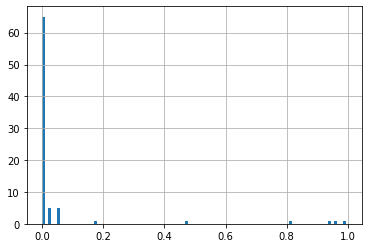

In [94]:
missing_stats['missing_percentage'].hist(bins=100)

In [95]:
# compute and skip features with no missing
missing_stats = missing_stats[missing_stats['missing_count'] != 0]
missing_stats

,feature,missing_count,missing_percentage,feature_type
3,LotFrontage,259,0.177397,float64
6,Alley,1369,0.937671,object
25,MasVnrType,8,0.005479,object
26,MasVnrArea,8,0.005479,float64
30,BsmtQual,37,0.025342,object
31,BsmtCond,37,0.025342,object
32,BsmtExposure,38,0.026027,object
33,BsmtFinType1,37,0.025342,object
35,BsmtFinType2,38,0.026027,object
42,Electrical,1,0.000685,object


I'll consider that when more than 50% of the data is missing, we should delete the corresponding variable and pretend it never existed. This means that we will not try any trick to fill the missing data in these cases. According to this, there is a set of variables (e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.) that we should delete.

for the rest of feature, I'll handle the missing data by filling by const and mode for Categorical, KNN for numric

Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.

# I will decide to delete all features with more than 50% 

In [96]:
features_to_delete = missing_stats[missing_stats['missing_percentage'] > 0.50]['feature'].values
features_to_delete

array(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype=object)

In [97]:
train_df.drop(columns=features_to_delete, inplace=True)

we will also drop MasVnrArea, MasVnrType as described above

In [98]:
train_df.drop(columns=['MasVnrArea','MasVnrType'], inplace=True)

In [99]:
# recompute and skip features with no missing
missing_stats = get_feature_stats(train_df)
missing_stats = missing_stats[missing_stats['missing_count'] != 0]
missing_stats

,feature,missing_count,missing_percentage,feature_type
3,LotFrontage,259,0.177397,float64
27,BsmtQual,37,0.025342,object
28,BsmtCond,37,0.025342,object
29,BsmtExposure,38,0.026027,object
30,BsmtFinType1,37,0.025342,object
32,BsmtFinType2,38,0.026027,object
39,Electrical,1,0.000685,object
54,FireplaceQu,690,0.472603,object
55,GarageType,81,0.055479,object
56,GarageYrBlt,81,0.055479,float64


Fill Categorical Missing Values

According to data description, Na in the features bellow doesn't mean its missing, it means that house doesn't have that feature

example => when FireplaceQu is Na, it means number of Fireplace in that house is zero 
i'll handle them by filling them with constant "None"

In [100]:
for column in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
               'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
               'GarageQual', 'GarageCond']:
    train_df[column] = train_df[column].fillna("None")

In [101]:
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])

Numeric Missing Values

In [102]:
from sklearn.neighbors import KNeighborsRegressor

In [103]:
def knn_impute(df, na_target):
    df_copy = df.copy()
    
    numeric_df = df_copy.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df_copy.loc[df_copy[na_target].isna() == True, na_target] = y_pred
    
    return df_copy

In [104]:
for column in ['LotFrontage', 'GarageYrBlt']:
    train_df = knn_impute(train_df, column)

In [105]:
# recompute and skip features with no missing
missing_stats = get_feature_stats(train_df)
missing_stats = missing_stats[missing_stats['missing_count'] != 0]
missing_stats

,feature,missing_count,missing_percentage,feature_type


### Cool, Now we have no missing data at all

Now we can go to the next stage 

I'll delete Id column and restart its count from 0

In [106]:
clean_df = train_df.drop(columns=['Id'])

In [107]:
columns_type = get_feature_types_stats(clean_df)

quantitative_features = columns_type[columns_type['feature_type'] != 'object']['feature'].tolist()
qualitative_features = columns_type[columns_type['feature_type'] == 'object']['feature'].tolist()

# EDA

In [108]:
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns

### Categorical data
With qualitative variables we can implement two methods. First one is to check distribution of SalePrice with respect to variable values and enumerate them. Second to create dummy variable for each possible category.

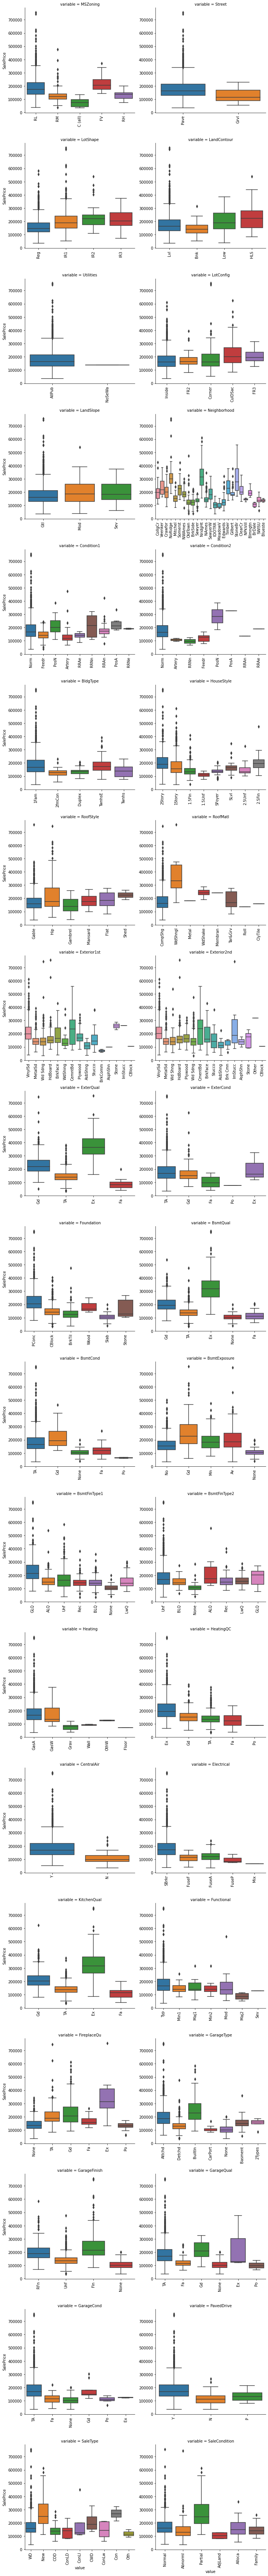

In [109]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(clean_df, id_vars=['SalePrice'], value_vars=qualitative_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

Some categories seem to more diverse with respect to SalePrice than others. Neighborhood has big impact on house prices. Most expensive seems to be Partial SaleCondition. Having pool on property seems to improve price substantially. There are also differences in variabilities between category values.

<AxesSubplot:>

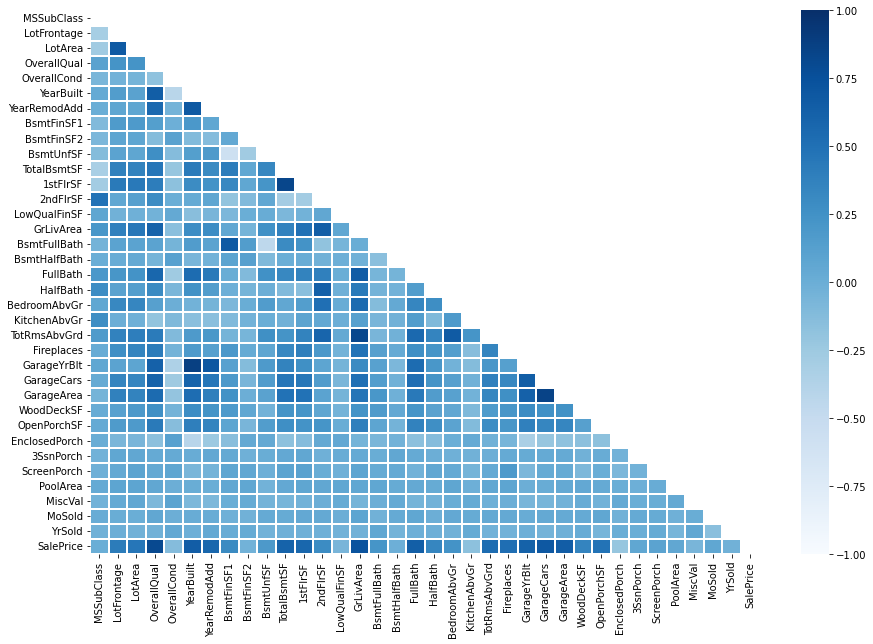

In [110]:
# Calculate correlations
corr = clean_df.corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr,
            vmax=1,
            vmin=-1,
            mask=mask,
            #annot=True, 
            fmt='.2f',
            linewidths=.2, cmap="Blues")

There are few things that attarct my attention:

* First, we can observe dark blue squares around garage features, this shows high correlation between these features, we might have to drop some features here and pick the best one out. We also have correlation of about 0.8 between GrlivArea and TotRmsAbvGrd, BedroomAbvGrd and TotRmsAbvGrd,YearBuilt and GarageYrBlt.


* Second, OverallQual, YearBuilt, YearRemodAdd, MasVnrArea, GrLivArea, FullBath, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF are best correlated with the target, lets also check them out more closely.


* Third, Observe how at the bottom and right side of the heat map we just have a light blue colored region, this is a good thing only if features contributing to this light blue colored region were highly correlated to the Target, which is not the case, which tells us that there is no information present in these features, we will perform follow up analysis to check this inference.

Focusing only on the 'SalePrice' feature (bottom row), we can see strong correlations with various variables including OverallQual, GrLivArea, and GarageCars - all three of these intuitively make sense that they would strongly affect a home's price. However, let's not forget that Pearson's correlation factor only picks up linear relationships, more complex relationships surely exist between other features and the target feature.

### Looking at the top 10 most correlated features with SalePrice

<AxesSubplot:>

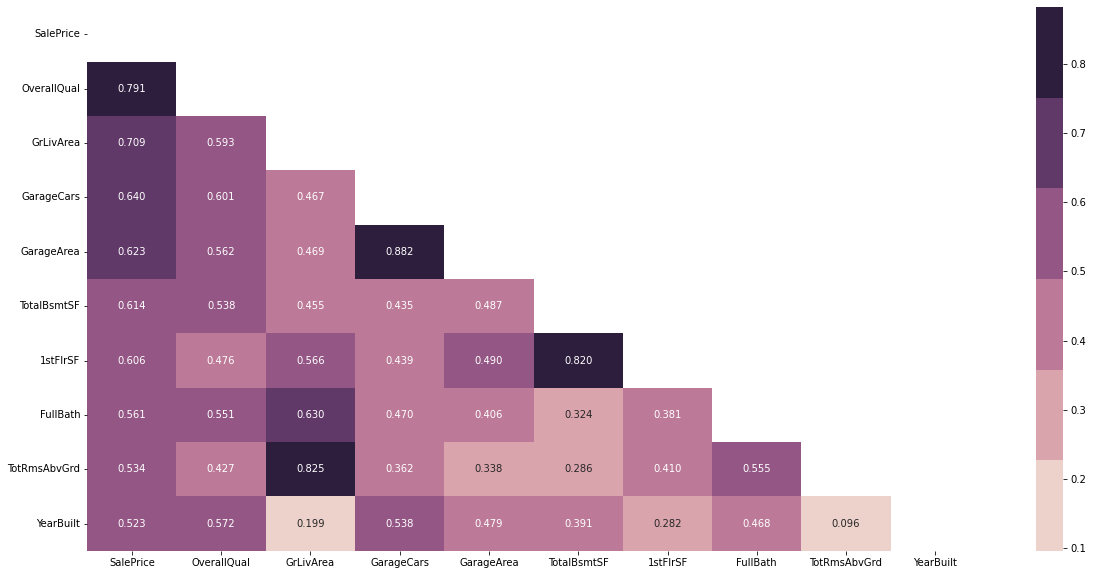

In [111]:
corr_feat = clean_df.corr().nlargest(10,"SalePrice")["SalePrice"].index
cmap = np.corrcoef(clean_df[corr_feat].values.T)
mask = np.zeros_like(cmap,dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,10))
sns.heatmap(cmap,
            annot=True,
            fmt=".3f",
            annot_kws = {"size":10},
            cmap=sns.cubehelix_palette(),
            xticklabels = corr_feat.values,
            yticklabels = corr_feat.values,
            mask=mask)

They have great impact on the house price, but I believe that there are more feature that may have more powerful impact on the house price like PoolArea, utilities, Neighborhood, etc. 

Neighborhood confirms the idea that houses in same region share same characteristics

the increase of PoolArea shows how luxury the house is 

### Pairplots
It also would be useful to see how sale price compares to each independent quantitative variable

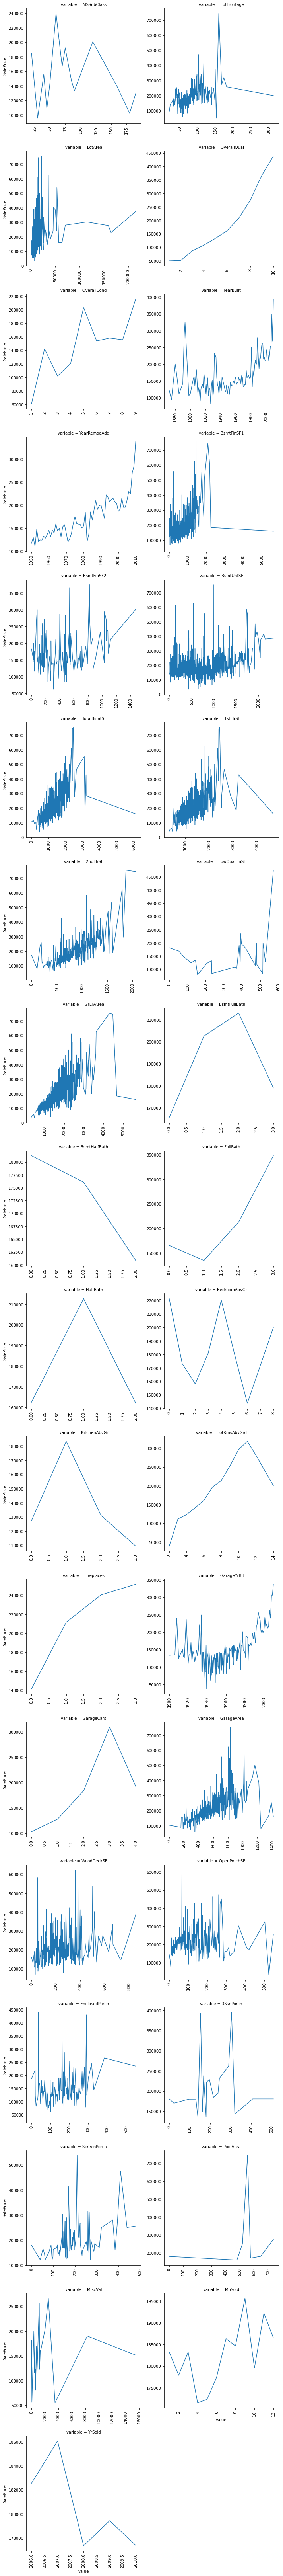

In [112]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(clean_df, id_vars=['SalePrice'], value_vars=quantitative_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "SalePrice")

There are lots of nonlinearities this may be the cause why some variables won't be selected. Some factors like YearBuilt, 1stFlrSF, 2ndFlrSF look like they would benefit from adding quadratic term to regression.

## Feature Engineering

### Studying features that have smiliarties in names, and their correlation with the target variable

In [113]:
def feature_vs_target(feature_name):
    print("Feature: {}  & Correlation with target: {}"
          .format(feature_name,clean_df[feature_name].corr(clean_df['SalePrice'])))
    
    fig=plt.figure(figsize=(20,4))

    ax=fig.add_subplot(1,3,1)
    ax.hist(clean_df[feature_name])
    ax.set_title("train subplot", fontsize = 20)
    ax.set_xlabel(feature_name,fontsize=20)
    ax.tick_params(labelsize=13)
    

    ax=fig.add_subplot(1,3,2)
    ax.scatter(clean_df[feature_name],clean_df['SalePrice'])
    ax.set_title(feature_name+" vs SalesPrice", fontsize = 20)
    ax.set_xlabel(feature_name,fontsize=20)
    ax.set_ylabel("SalesPrice",fontsize=20)
    ax.tick_params(labelsize=13)

Feature: OverallCond  & Correlation with target: -0.077855894048678


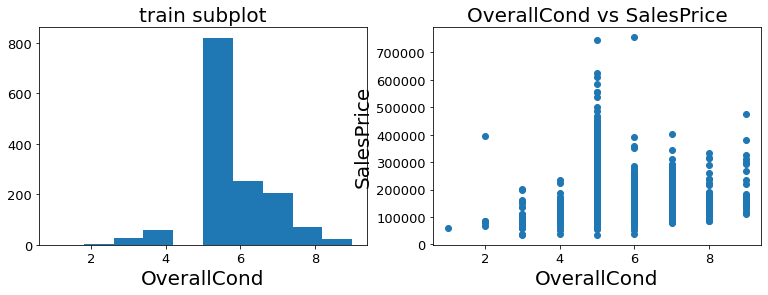

In [114]:
feature_vs_target("OverallCond")

Feature: OverallQual  & Correlation with target: 0.7909816005838052


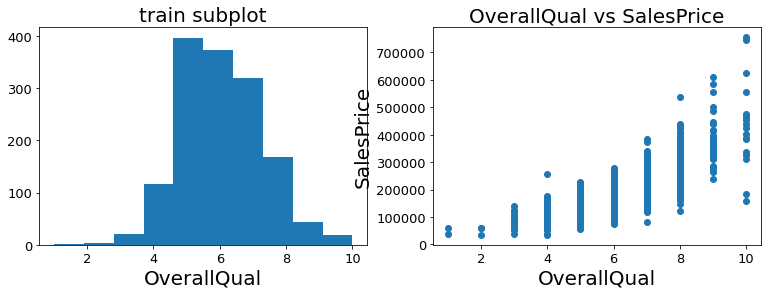

In [115]:
feature_vs_target('OverallQual')

OverallQual: Rates the overall material and finish of the house

OverallCond: Rates the overall condition of the house

OverallQual feature positivly correaltion with target variable SalesPrice. means higher OverallQual value of house sold at higher price. 

But, OverallCond hasn't any relationship with target variable(SalesPrice). 

Above scatter plot depicts that, some house with OverallCond value 5 has sold at higher price. Hence, this feature alone isn't helpful.

Feature: cond*qual  & Correlation with target: 0.5652938448019197


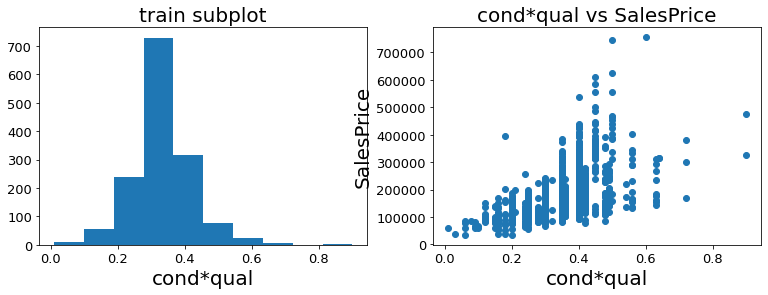

In [116]:
clean_df['cond*qual'] = (clean_df['OverallCond'] * clean_df['OverallQual']) / 100.0

feature_vs_target('cond*qual')

Looks normal more than both independent variables, and thats we want

we have to drop OverallCond and OverallQual

In [117]:
columns_to_drop = ['OverallCond', 'OverallQual']

Feature: YearBuilt  & Correlation with target: 0.5228973328794968


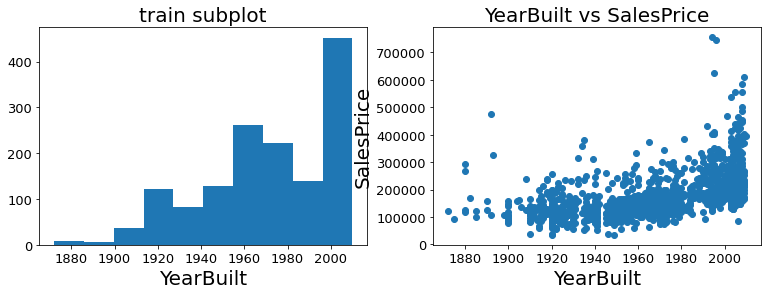

In [118]:
feature_vs_target('YearBuilt')

YearBuilt feature has somewhat linear relationship with SalesPrice.

the data also contains one feature YrSold (year sold). 
Using these two feature YearBuilt and YrSold, we can generate new feature home age. It means how the house was old when it was sold.

In [119]:
clean_df['home_age_when_sold'] = clean_df['YrSold'] - clean_df['YearBuilt']

Feature: home_age_when_sold  & Correlation with target: -0.5233504175468159


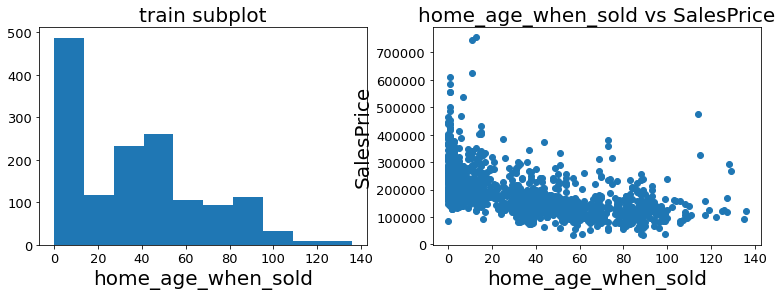

In [120]:
feature_vs_target('home_age_when_sold')

We drop YrSold and YearBuilt, we have home_age_when_sold instead which provides more information gain

In [121]:
columns_to_drop += ['YrSold', 'YearBuilt']

Feature: YearRemodAdd  & Correlation with target: 0.5071009671113862


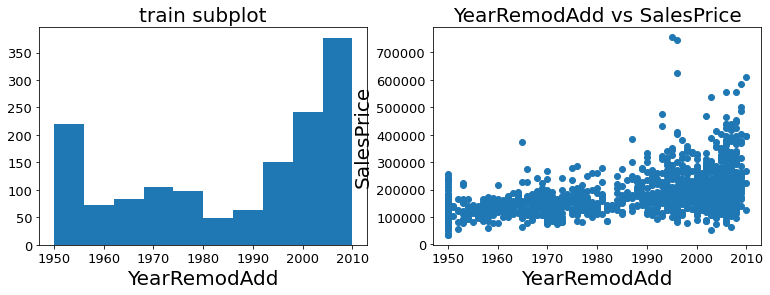

In [122]:
feature_vs_target('YearRemodAdd')

We can also generate one new feature using YearRemodAdd feature.

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

new_feature is Home age after renovation

In [123]:
clean_df['after_remodel_home_age_when_sold'] = clean_df['YrSold'] - clean_df['YearRemodAdd']

Feature: after_remodel_home_age_when_sold  & Correlation with target: -0.5090787380156294


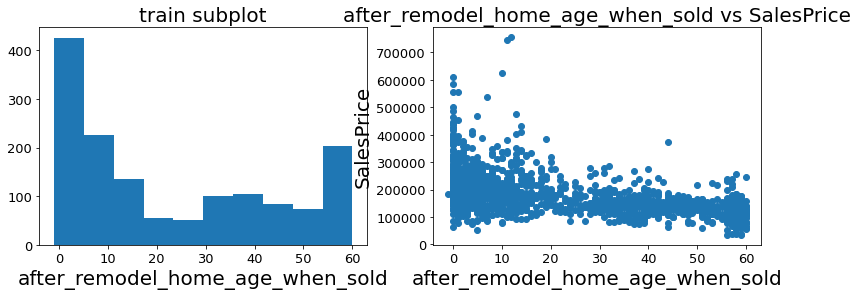

In [124]:
feature_vs_target('after_remodel_home_age_when_sold')

We drop YearRemodAdd, we have after_remodel_home_age_when_sold instead which provides more information gain

In [125]:
columns_to_drop += ['YearRemodAdd']

Feature: BsmtFinSF1  & Correlation with target: 0.3864198062421531


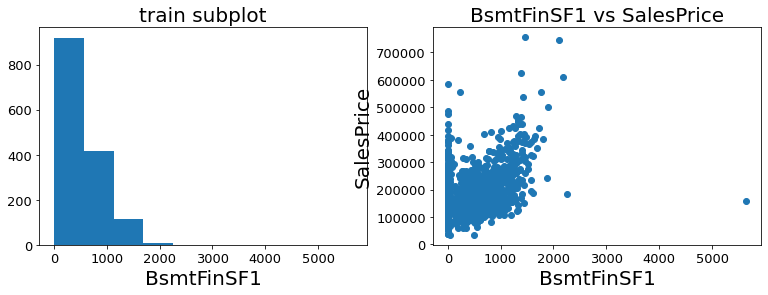

In [126]:
feature_vs_target('BsmtFinSF1')

Feature: BsmtFinSF2  & Correlation with target: -0.011378121450215137


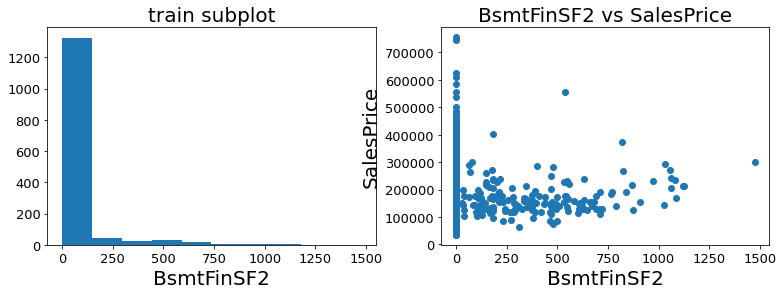

In [127]:
feature_vs_target('BsmtFinSF2')

There are lots of home with 0 value of BsmtFinSF2 feature.

In [128]:
print("Number of homes which has BsmtFinSF2 : {}%" 
      .format(((clean_df['BsmtFinSF2']!=0).sum() / clean_df.shape[0])*100))

Number of homes which has BsmtFinSF2 : 11.438356164383562%


BsmtFinSF2 feature is not looking useful.

We could make new feature using BsmtFinSF1 & BsmtFinSF2

BsmtFinSF1: Type 1 finished square feet

BsmtFinSF2: Type 2 finished square feet

Feature: BsmtFinSF1+BsmtFinSF2  & Correlation with target: 0.36632769193495623


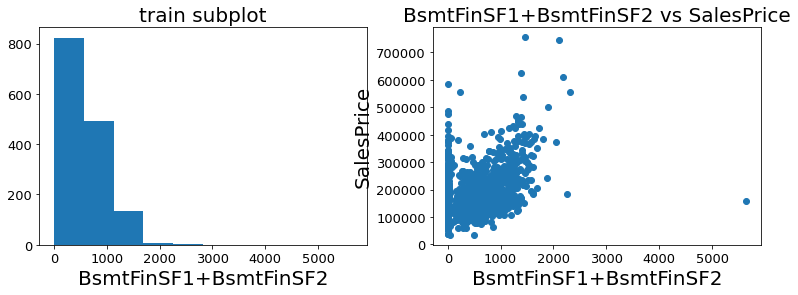

In [129]:
clean_df['BsmtFinSF1+BsmtFinSF2'] = clean_df['BsmtFinSF1'] + clean_df['BsmtFinSF2']

feature_vs_target('BsmtFinSF1+BsmtFinSF2')

I'll use this feature, so i must remove BsmtFinSF1 & BsmtFinSF2 feature as we have already use it.

In [130]:
columns_to_drop += ['BsmtFinSF1', 'BsmtFinSF2']

Feature: BsmtUnfSF  & Correlation with target: 0.2144791055469689


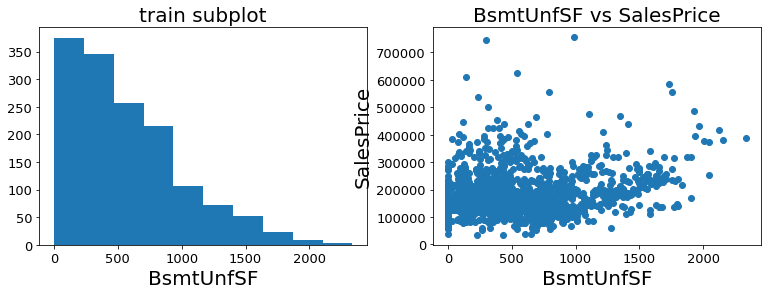

In [131]:
feature_vs_target("BsmtUnfSF")

Feature: TotalBsmtSF  & Correlation with target: 0.6135805515591954


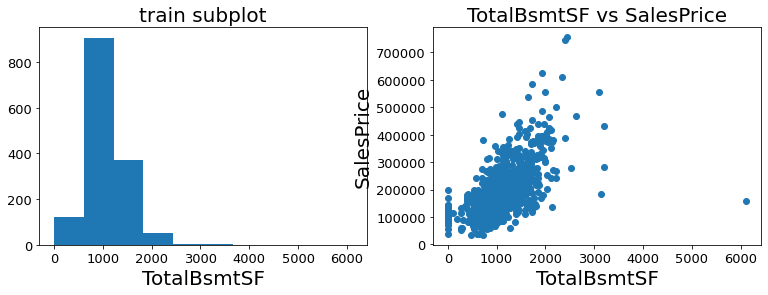

In [132]:
feature_vs_target('TotalBsmtSF')

Here we have redundant data, TotalBsmtSF = BsmtUnfSF + BsmtFinSF1 + BsmtFinSF2

we can drive one of the other two, so i'll decide to delete BsmtUnfSF

In [133]:
columns_to_drop += ['BsmtUnfSF']

Feature: 1stFlrSF  & Correlation with target: 0.6058521846919145


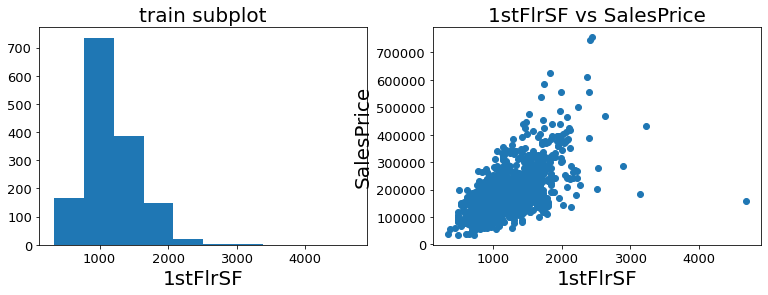

In [134]:
feature_vs_target("1stFlrSF")

Feature: 2ndFlrSF  & Correlation with target: 0.3193338028320677


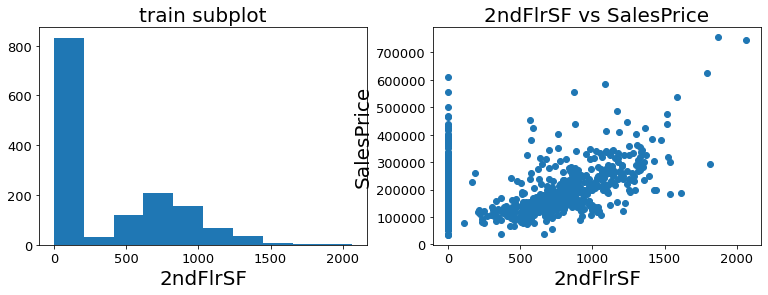

In [135]:
feature_vs_target("2ndFlrSF")

2ndFlrSF feature is linearly correlated with target SalesPrice.

Using 1stFlrSF, 2ndFlrSF and TotalBsmtSF features, we would generate new feature total_SF

TotalBsmtSF: Total square feet of basement area
1stFlrSF: First Floor square feet
2ndFlrSF: Second floor square feet

Feature: TotalSF  & Correlation with target: 0.782260052797984


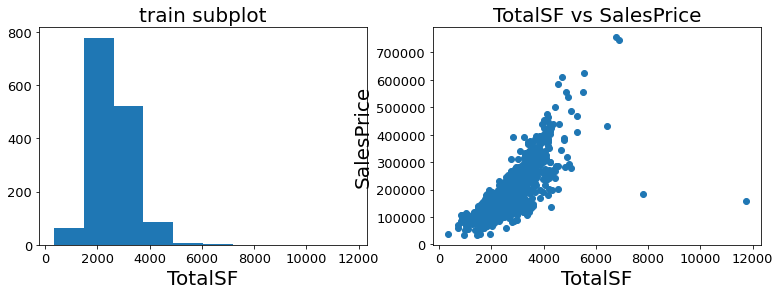

In [136]:
clean_df['TotalSF'] = clean_df['TotalBsmtSF'] + clean_df['1stFlrSF'] + clean_df['2ndFlrSF']

feature_vs_target('TotalSF')

this created new TotalSF feature is highly correalted with Salesprice. Great!

In [137]:
columns_to_drop += ['TotalBsmtSF']

Feature: GrLivArea  & Correlation with target: 0.7086244776126521


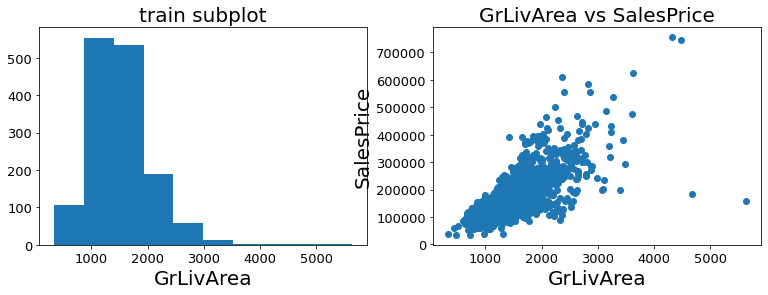

In [138]:
feature_vs_target('GrLivArea')

GrLivArea: Above grade (ground) living area square feet

it has a good correlation with the target variable

We have 4 related features about Bathrooms ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']

we can generate one new feature using these all bathoom related features.

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Feature: FullBath  & Correlation with target: 0.5606637627484456


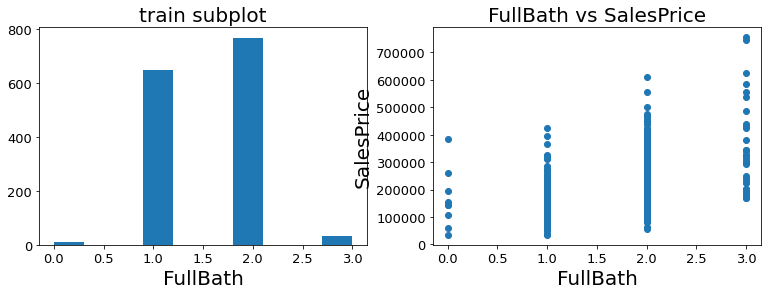

In [139]:
feature_vs_target('FullBath')

Feature: HalfBath  & Correlation with target: 0.2841076755947825


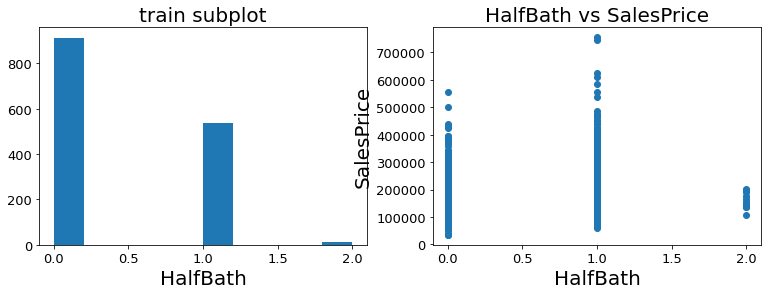

In [140]:
feature_vs_target('HalfBath')

Feature: BsmtFullBath  & Correlation with target: 0.22712223313149438


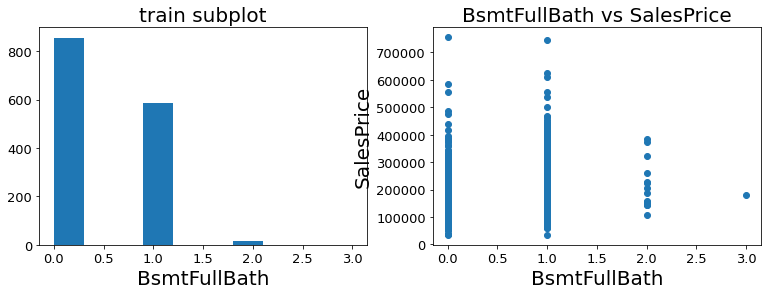

In [141]:
feature_vs_target('BsmtFullBath')

Feature: BsmtHalfBath  & Correlation with target: -0.01684415429735901


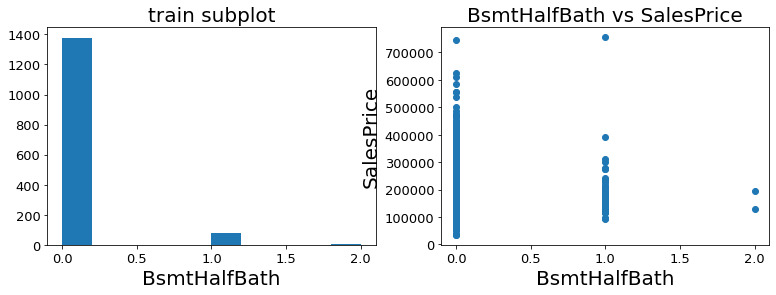

In [142]:
feature_vs_target('BsmtHalfBath')

Feature: Total_Bathrooms  & Correlation with target: 0.6317310679319874


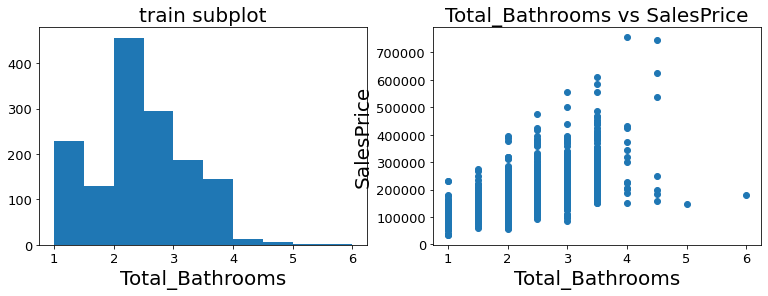

In [143]:
clean_df['Total_Bathrooms'] = (clean_df['FullBath'] +
                               (0.5 * clean_df['HalfBath']) +
                               clean_df['BsmtFullBath'] +
                               (0.5 * clean_df['BsmtHalfBath']))

feature_vs_target('Total_Bathrooms')

This new generated Total_Bathrooms feature has good correlation with target Salesprice feature.

In [144]:
columns_to_drop += ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']

In [145]:
clean_df.drop(columns=columns_to_drop, inplace=True)

## Log Transform for Skewed Features

## Skewness

Skewness is a measure of the symmetry in a distribution.

A symmetrical dataset will have a skewness equal to 0. So, a normal distribution will have a skewness of 0. Skewness essentially measures the relative size of the two tails.

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical

If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed

If the skewness is less than -1 or greater than 1, the data are highly skewed

In [146]:
import scipy

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice'>

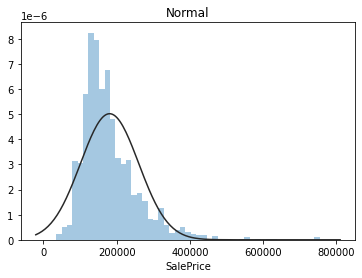

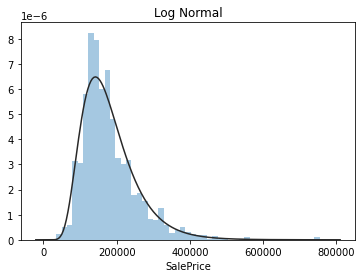

In [147]:
y = clean_df['SalePrice']

plt.figure(1); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(2); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

It is apparent that SalePrice doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job


As we can see on the plot, the distribution of 'SalePrice' is right-skewed which is reflected in the skewness factor which is positive. We would like to get the skewness factor as close to zero as possible

This can accomplished by either removing outliers or transforming the variable. Removing outliers may be tricky as expertise in real estate is needed to assess whether whether outliers should be removed or not. Applying transformations is typically a safer option if it can deliver the desired outcome. In the case of positive skewness, log transformation does the trick.

In [148]:
skew_df = pd.DataFrame(clean_df.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(clean_df[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,MSSubClass,1.406210,1.406210,True
1,LotFrontage,2.020591,2.020591,True
2,LotArea,12.195142,12.195142,True
3,1stFlrSF,1.375342,1.375342,True
4,2ndFlrSF,0.812194,0.812194,True
5,LowQualFinSF,9.002080,9.002080,True
6,GrLivArea,1.365156,1.365156,True
7,BedroomAbvGr,0.211572,0.211572,False
8,KitchenAbvGr,4.483784,4.483784,True
9,TotRmsAbvGrd,0.675646,0.675646,True


In [149]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    clean_df[column] = np.log1p(clean_df[column])

In [150]:
clean_df_copy = clean_df.copy()
clean_df_copy.drop(columns=["SalePrice"], inplace=True)
clean_df_copy.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SaleType',
       'SaleCondition', 'cond*qual', 'home_age_when_sold',
       'after_remodel_home_age_when_sold', 'Bsm

In [151]:
columns_type = get_feature_types_stats(clean_df)

qualitative_features = columns_type[columns_type['feature_type'] == 'object']['feature'].tolist()

In [152]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

In [153]:
column_transformer = make_column_transformer(
    (OneHotEncoder(), qualitative_features)
)

In [154]:
transformer_data = column_transformer.fit_transform(clean_df)
encoded_column_names = column_transformer.transformers_[0][1].get_feature_names_out()

clean_df[encoded_column_names] = transformer_data.toarray()
clean_df[encoded_column_names]

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [155]:
clean_df.drop(columns=qualitative_features, inplace=True)

## Cross validation 

In [156]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
import pickle
from sklearn.pipeline import make_pipeline

In [157]:
target_variable = clean_df['SalePrice']
clean_df.drop(columns=['SalePrice'], inplace=True)

In [158]:
#some values were too large which float32 couldn't contain 
train_inf = np.isinf(clean_df)
clean_df[train_inf] = 0

In [159]:
kf = KFold(n_splits=5)

knn_best_model = None
knn_best_score = 0
k_scores = []

rf_best_model = None
rf_best_score = 0
rf_scores = []

gbt_best_model = None
gbt_best_score = 0
gbt_scores = []

poly_best_model = None
poly_best_score = 0
poly_scores = []

for train_index, test_index in kf.split(clean_df):
    X_train, X_test = clean_df.iloc[train_index], clean_df.iloc[test_index]
    y_train, y_test = target_variable.iloc[train_index], target_variable.iloc[test_index]

    #Knn section
    #Leaf size passed to BallTree or KDTree.
    leaf_size = list(range(10,50))
    #Number of neighbors
    n_neighbors = list(range(3,8))
    #Power parameter for the Minkowski metric 
    p=[1,2]

    #Convert to dictionary
    knn_hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

    knn = KNeighborsRegressor()
    random_search_knn = RandomizedSearchCV(estimator = knn, # the base model
                                           param_distributions = knn_hyperparameters, # grid of hyper parameters
                                           random_state=1,
                                           n_jobs = 1, # use all cores in the machine to train (parallel)
                                           cv = 5) # 5-fold

    search = random_search_knn.fit(X_train, y_train)
    
    knn_test = KNeighborsRegressor(**search.best_params_)
    knn_test.fit(X_train, y_train)
    knn_score = knn_test.score(X_test, y_test)

    if knn_score > knn_best_score:
        knn_best_score = knn_score
        knn_best_model = knn_test
    
    k_scores.append(knn_score)

    #Random forest section
    #number of trees in the foreset
    n_estimators = [75, 100, 120, 150]
    #max number of levels in each decision tree
    max_depth = [5, 8, 15, 25, 30, 40]
    #min number of data points placed in a node before the node is split
    min_samples_split = [2, 5, 7, 10]
    #min number of data points allowed in a leaf node. 
    # A split point at any depth will only be considered if it leaves at least
    min_samples_leaf = [1, 2, 5, 10]

    random_forest = RandomForestRegressor()

    rf_hyperparameters = {'n_estimators': n_estimators, 
                           'max_depth': max_depth,
                           'min_samples_split': min_samples_split,
                           'min_samples_leaf': min_samples_leaf}

    random_search_rf = RandomizedSearchCV(estimator = random_forest,
                                           param_distributions = rf_hyperparameters,
                                           random_state=1,
                                           n_jobs = 1,
                                           cv = 5)
    #to get best hyperparameters
    search = random_search_rf.fit(X_train, y_train)

    #return the model using best hyperparameters
    rf_test = RandomForestRegressor(**search.best_params_)
    rf_test.fit(X_train, y_train)
    rf_score = rf_test.score(X_test, y_test)

    if rf_score > rf_best_score:
        rf_best_score = rf_score
        rf_best_model = rf_test
    
    rf_scores.append(rf_score)

    #Polynomial section
    degree = [1, 2]
    alphas = [1e-3, 1e-2]

    for index in range(2):
        est = make_pipeline(PolynomialFeatures(degree[index]), Lasso(alpha=alphas[index]))
        est.fit(X_train, y_train)
        poly_score = est.score(X_test, y_test)

        if poly_score > poly_best_score:
            poly_best_score = poly_score
            poly_best_model = est
            
        poly_scores.append(poly_score)
        
    #GBT section
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 120, stop = 200, num = 5)]
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 74, num = 10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [5, 10, 16]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [2, 4, 7]
    # Method of selecting samples for training each tree
    learning_rate = [0.01, 0.1]
    # Create the random grid
    gbt_hyperparameters = {'n_estimators': n_estimators, 
                           'max_depth': max_depth,
                           'min_samples_split': min_samples_split,
                           'min_samples_leaf': min_samples_leaf,
                           'learning_rate': learning_rate}

    gbt = GradientBoostingRegressor()
    
    gbt_random = RandomizedSearchCV(estimator = gbt, 
                               param_distributions = gbt_hyperparameters, 
                               n_iter = 10, # number of combinations of random hyper parameters to choose
                               cv = 5,
                               random_state=42,
                               n_jobs = 1) 

    search = gbt_random.fit(X_train, y_train)
    gbt_score = search.best_score_

    gbt_test = GradientBoostingRegressor(**search.best_params_)
    gbt_test.fit(X_train, y_train)
    gbt_score = gbt_test.score(X_test, y_test)

    if gbt_score > gbt_best_score:
        gbt_best_score = gbt_score
        gbt_best_model = gbt_test
    
    gbt_scores.append(gbt_score)

best score for polynomial: 0.8323565588327669
list of scores for polynomial: [0.83235656 0.81565043 0.80339341 0.77193163 0.80960442 0.74968627
 0.81753583 0.75716008 0.75324889 0.7076353 ]


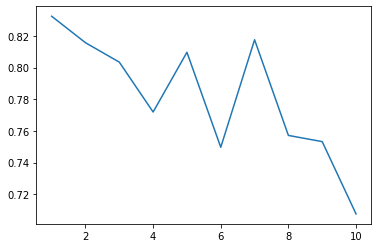

In [169]:
print(f"best score for polynomial: {poly_best_score}")
print(f"list of scores for polynomial: {poly_scores}")

plt.plot([x for x in range(1,11)], poly_scores)

best score for knn: 0.727212862033916
list of scores for knn: [0.727212862033916, 0.7070693211043666, 0.7097697478811062, 0.6449316453723823, 0.7116089732816153]


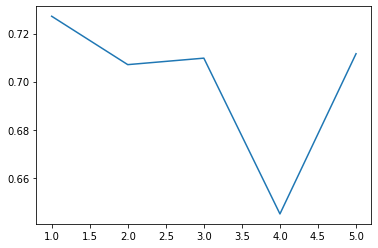

In [161]:
print(f"best score for knn: {knn_best_score}")
print(f"list of scores for knn: {k_scores}")

plt.plot([x for x in range(1,6)], k_scores)

best score for random forest: 0.9021303103391234
list of scores for random forest: [0.8993001522363154, 0.8658824230298154, 0.8837992389176824, 0.9021303103391234, 0.8701738177500682]


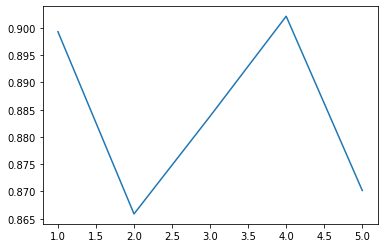

In [162]:
print(f"best score for random forest: {rf_best_score}")
print(f"list of scores for random forest: {rf_scores}")

plt.plot([x for x in range(1,6)], rf_scores)

best score for gradient boost trees: 0.9200093088951795
list of scores for gradient boost trees: [0.9062139144537235, 0.8873945438943671, 0.9001093574228587, 0.9200093088951795, 0.896545665880263]


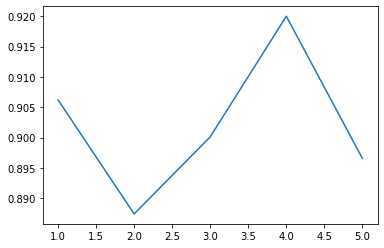

In [163]:
print(f"best score for gradient boost trees: {gbt_best_score}")
print(f"list of scores for gradient boost trees: {gbt_scores}")

plt.plot([x for x in range(1,6)], gbt_scores)

as we see the best model was gbt, so i'll train it using the entire dataset and pickle it into memory

In [164]:
gbt_best_model

GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                          n_estimators=140)

best hyperparameters were: 
max_depth=5, min_samples_leaf=2, min_samples_split=16,
                          n_estimators=125

In [165]:
final_gbt_model = GradientBoostingRegressor(max_depth=5, min_samples_leaf=2,
                                            min_samples_split=16,n_estimators=125)
final_gbt_model.fit(clean_df, target_variable)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=16,
                          n_estimators=125)

In [166]:
pipeline = make_pipeline(column_transformer, final_gbt_model)
pipeline.fit(clean_df_copy, target_variable)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['MSZoning', 'Street',
                                                   'LotShape', 'LandContour',
                                                   'Utilities', 'LotConfig',
                                                   'LandSlope', 'Neighborhood',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'ExterQual', 'ExterCond',
                                                   'Foundation', 'BsmtQual',
                                                   'B

In [170]:
clean_df_copy.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SaleType',
       'SaleCondition', 'cond*qual', 'home_age_when_sold',
       'after_remodel_home_age_when_sold', 'Bsm

In [168]:
pickle.dump(pipeline, open('./model.sav', 'wb'))